## Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.grid_search import GridSearchCV
from sklearn import linear_model

## Some useful methods

In [54]:
def norm_data(data):
    scaler = preprocessing.StandardScaler().fit(data)
    return scaler.transform(data)

def get_XY(df, y_label):
    yn = df[y_label].as_matrix()
    Xn = df.drop(y_label, axis=1).as_matrix()

    return Xn, yn

def emp_length_mapping(lst):
    mapping = {}
    for elem in lst:
        if elem in ["n/a", "< 1 year"]:
            mapping[elem] = 0
        else:
            mapping[elem] = int(elem.split()[0].strip("+"))
        
    return mapping

def target_mapping(lst):
    mapping = {}
    for elem in lst:
        if elem in ["Default", "Charged Off", "Late (31-120 days)",
                   "Does not meet the credit policy. Status:Charged Off"]:
            mapping[elem] = 1
        else:
            mapping[elem] = 0
    
    return mapping

def threshold(vec, value):
    for i in range(len(vec)):
        if vec[i] >= value:
            vec[i] = 1
        else:
            vec[i] = 0
    return vec.astype(int)

def acc(y_correct, y_pred):
    acc = 0
    for i in range(len(y_pred)):
        acc += y_pred[i] == y_correct[i]
    
    return acc / len(y_pred)
    
pd.set_option('display.max_columns', None)
%matplotlib inline

## Read data from csv

In [3]:
data = pd.read_csv("loan.csv", sep=",", error_bad_lines=False, low_memory=False,
                   parse_dates=["issue_d", "earliest_cr_line", "last_pymnt_d",
                                "next_pymnt_d", "last_credit_pull_d"])
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,2015-01-01,171.62,NaT,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,NaT,2013-09-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,2014-06-01,649.91,NaT,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,2015-01-01,357.48,NaT,2015-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,2016-01-01,67.79,2016-02-01,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

### NULL values

Let's see how many NULL values we have in our data!

In [4]:
data.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       51457
emp_length                          0
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           761350
purpose                             0
title                             151
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

Unfortunately there are columns where most of values are NULLs. They are completely useless, so just remove those columns where more than 1% of the rows for that column contain a null value.

In [22]:
cleaned_data = data[[label for label in data if data[label].isnull().sum() <= 0.01 * data.shape[0]]]

Let's see how it looks like now!

In [23]:
cleaned_data.isnull().sum()

id                              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
emp_length                      0
home_ownership                  0
annual_inc                      4
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
url                             0
purpose                         0
title                         151
zip_code                        0
addr_state                      0
dti                             0
delinq_2yrs                    29
earliest_cr_line               29
inq_last_6mths                 29
open_acc                       29
pub_rec                        29
revol_bal                       0
revol_util    

Ok, much better. Now we have to do something with those NULL values. 
We can: 
- remove rows cointain NULL values, 
- fill them with median or mode value,
- or use some imputation and try to predict their missing values.

Let's try first option and see what will happen.

In [24]:
cleaned_data = cleaned_data.dropna()
cleaned_data.shape[0] / data.shape[0]

0.999080438009013

It looks good, we removed less than 1% of rows. I think it's good enough and there's no point to do something more with that.

### Remove useless columns

Let's take a look on data.

In [25]:
cleaned_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,1.0,INDIVIDUAL,0.0
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,1.0,INDIVIDUAL,0.0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,1.0,INDIVIDUAL,0.0


- As we can see, two first columns contain randomly generated numbers, which are some identifiers. The column "url" also contains information about id,

- What's more, "zip_code" is redundant with the "addr_state" and only 3 digits of 5 digit code zip are visible,

- According to: https://www.lendingclub.com/public/rates-and-fees.action column sub_grade is reduntant to columns "grade" and "int_rate",

- "title" column requires a lot of processing to become usefull.

In [26]:
cleaned_data = cleaned_data.drop(["id", "member_id", "sub_grade", "url", "zip_code", "title"], axis=1)
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,1.0,INDIVIDUAL,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,1.0,INDIVIDUAL,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,other,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,1.0,INDIVIDUAL,0.0


### Columns with only one value

Or not only one, but with values which have insignificant frequencies.

In [27]:
for label in list(cleaned_data):
    if len(cleaned_data[label].unique()) < 5:
        print(cleaned_data[label].value_counts())
        print("\n")

 36 months    620487
 60 months    266076
Name: term, dtype: int64


Source Verified    329332
Verified           290835
Not Verified       266396
Name: verification_status, dtype: int64


n    886553
y        10
Name: pymnt_plan, dtype: int64


f    456364
w    430199
Name: initial_list_status, dtype: int64


1.0    886563
Name: policy_code, dtype: int64


INDIVIDUAL    886061
JOINT            502
Name: application_type, dtype: int64




We can see that feature "pymnt_plan" has only two possible values: "n" and "y", but with only 10 occurrences of "y" (less than 1%), so definitely it is insignificant. The same with "application_type" feature: value "joint" has 0,05% frequency. 
On the other hand, feature "policy_code" has only one possible value, so it's absolutely useless for us.

In [28]:
cleaned_data = cleaned_data.drop(["pymnt_plan", "policy_code", "application_type"], axis=1)
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,other,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,0.0


### Target  column

In [29]:
list(cleaned_data["loan_status"].unique())

['Fully Paid',
 'Charged Off',
 'Current',
 'Default',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Issued']

Our goal is to prepare predictive model of default. Default client is defined as one with loan_status variable taking on the following levels: 'Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off'. So this values we will define as ones and the rest as zeros.

In [30]:
cleaned_data["loan_status"] = cleaned_data["loan_status"].map(target_mapping(cleaned_data["loan_status"].unique()))

### Categorical features

To use any machine learning model we have to have only numerical data. So, let's do something with our non-numerical features!

In [31]:
cleaned_data.select_dtypes(include=["object"]).head()

,term,grade,emp_length,home_ownership,verification_status,purpose,addr_state,initial_list_status
0,36 months,B,10+ years,RENT,Verified,credit_card,AZ,f
1,60 months,C,< 1 year,RENT,Source Verified,car,GA,f
2,36 months,C,10+ years,RENT,Not Verified,small_business,IL,f
3,36 months,C,10+ years,RENT,Source Verified,other,CA,f
4,60 months,B,1 year,RENT,Source Verified,other,OR,f


- "initial_list_status" has only 2 possible values, so we can map it to 1/0 feature,
- "term" is a numerical feature, but we have to delete "months" from this,
- "emp_length" is also almost-numerical, just need some processing,
- "last_pymnt_amnt" is definitely numerical, so the parsing is enough,
- other features can be numerical after using pandas' "get_dummies()" method.

In [32]:
cleaned_data["initial_list_status"] = cleaned_data["initial_list_status"].map({"f": 1, "w": 0})
cleaned_data["term"] = cleaned_data["term"].str.split().str[0].astype("int")
cleaned_data["emp_length"] = cleaned_data["emp_length"].map(emp_length_mapping(cleaned_data["emp_length"].unique()))
cleaned_data["last_pymnt_amnt"] = cleaned_data["last_pymnt_amnt"].astype("float")
cleaned_data = pd.get_dummies(cleaned_data, columns=list(cleaned_data.select_dtypes(include=["object"])))

### Datetime features
We have datatype columns, but now it's useless - we have to extract some information from them.

In [33]:
cleaned_data.select_dtypes(include=["datetime"]).head()

,issue_d,earliest_cr_line,last_credit_pull_d
0,2011-12-01,1985-01-01,2016-01-01
1,2011-12-01,1999-04-01,2013-09-01
2,2011-12-01,2001-11-01,2016-01-01
3,2011-12-01,1996-02-01,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01


In [34]:
datetime_features = list(cleaned_data.select_dtypes(include=["datetime"]))

for label in datetime_features:
    month_year = (cleaned_data[label].dt.month + cleaned_data[label].dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    cleaned_data[label + "_month_year_cnt"] = month_year.map(month_year_cnt_map)
    
    cleaned_data[label + "_year"] = cleaned_data[label].dt.year
    cleaned_data[label + "_month"] = cleaned_data[label].dt.month

cleaned_data = cleaned_data.drop(datetime_features, axis=1)

In [35]:
cleaned_data.shape

(886563, 120)

Finally we have 886563 rows and 120 columns (119 features + target) in our data.

#### Now we are ready to specify some models!

## Model

In [36]:
X, y = get_XY(cleaned_data, "loan_status")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

indexes = [j for j in range(len(X_train))]
np.random.shuffle(indexes)
X_train = X_train[indexes]
y_train = y_train[indexes]

X_train, X_test = norm_data(X_train), norm_data(X_test)

Well, data is so big and my computer doesn't have enough memory. I decided to choose only the most improtant features (20).

In [37]:
pca = PCA(n_components=20)
fit = pca.fit(X_train)
X_train = fit.transform(X_train)
X_test = fit.transform(X_test)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [39]:
knn_params = {"n_neighbors": [3, 5], "algorithm": ["auto", "ball_tree", "kd_tree"], 
               "weights": ["uniform", "distance"]}
clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, cv=3, n_jobs=-1, 
                   scoring="f1", verbose=10)

print("--- Start kNN training")
clf.fit(X_train, y_train)
print("--- Start kNN prediction on the validation set")
y_val_knn = clf.predict(X_val)
print("--- Start kNN prediction on the test set")
y_test_knn = clf.predict(X_test)
print("kNN: For params: %s we got results: acc: %.2f, f1: %.2f" % 
      (str(clf.best_params_), acc(y_val, y_val_knn), f1_score(y_val, y_val_knn)))

forest_params = {"n_estimators": [5, 10, 50], "max_depth": [2, 5, 7, 9]}
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=forest_params, cv=3, n_jobs=-1, 
                   scoring="f1", verbose=10)

print("--- Start Random Forest training")
clf.fit(X_train, y_train)
print("--- Start Random Forest prediction on the validation set")
y_val_forest = clf.predict(X_val)
print("--- Start Random Forest prediction on the test set")
y_test_forest = clf.predict(X_test)
print("Random Forest: For params: %s we got results: acc: %.2f, f1: %.2f" % 
      (str(clf.best_params_), acc(y_val, y_val_forest), f1_score(y_val, y_val_forest)))

svc_params = {"kernel": ["rbf"], "gamma": [0.001, 0.0001], "C": [1, 10, 100, 1000]}
clf = GridSearchCV(estimator=SVC(), param_grid=svc_params, cv=3, n_jobs=-1, 
                   scoring="f1", verbose=10)

print("--- Start SVM training")
clf.fit(X_train, y_train)
print("--- Start SVM prediction on the validation set")
y_val_svm = clf.predict(X_val)
print("--- Start SVM prediction on the test set")
y_test_svm = clf.predict(X_test)
print("SVM: For params: %s we got results: acc: %.2f, f1: %.2f" % 
      (str(clf.best_params_), acc(y_val, y_val_svm), f1_score(y_val, y_val_svm)))

results_val = pd.DataFrame({"svm": y_val_svm, "knn": y_val_knn, 
                            "forest": y_val_forest, "correct": y_val})
results_test = pd.DataFrame({"svm": y_test_svm, "knn": y_test_knn, "forest": y_test_forest})

--- Start kNN training
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV] algorithm=auto, n_neighbors=3, weights=distance .................
[CV]  algorithm=auto, n_neighbors=3, weights=uniform, score=0.477472 -42.5min
[CV] algorithm=auto, n_neighbors=3, weights=distance .................
[CV]  algorithm=auto, n_neighbors=3, weights=distance, score=0.472200 -42.9min
[CV] algorithm=auto, n_neighbors=3, weights=distance .................
[CV]  algorithm=auto, n_neighbors=3, weights=uniform, score=0.472305 -43.0min
[CV] algorithm=auto, n_neighbors=5, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=3, weights=uniform, score=0.473144 -43.4min
[CV] algorithm=auto, n_neighbors=5, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=3

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 84.1min


[CV]  algorithm=auto, n_neighbors=3, weights=distance, score=0.473626 -42.1min
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=uniform, score=0.476279 -47.5min
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=uniform, score=0.479539 -47.6min
[CV] algorithm=auto, n_neighbors=5, weights=distance .................
[CV]  algorithm=auto, n_neighbors=5, weights=uniform, score=0.473775 -48.8min
[CV] algorithm=ball_tree, n_neighbors=3, weights=uniform .............
[CV]  algorithm=auto, n_neighbors=5, weights=distance, score=0.476934 -49.9min
[CV] algorithm=ball_tree, n_neighbors=3, weights=uniform .............


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 134.9min


[CV]  algorithm=auto, n_neighbors=5, weights=distance, score=0.480190 -51.2min
[CV] algorithm=ball_tree, n_neighbors=3, weights=uniform .............
[CV]  algorithm=auto, n_neighbors=5, weights=distance, score=0.474137 -53.3min
[CV] algorithm=ball_tree, n_neighbors=3, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=3, weights=uniform, score=0.472305 -145.8min
[CV] algorithm=ball_tree, n_neighbors=3, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=3, weights=uniform, score=0.477472 -147.7min
[CV] algorithm=ball_tree, n_neighbors=3, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=3, weights=uniform, score=0.473144 -142.2min
[CV] algorithm=ball_tree, n_neighbors=5, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=3, weights=distance, score=0.472200 -141.3min
[CV] algorithm=ball_tree, n_neighbors=5, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=3, weights=distance, score=0.477354 -439

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 718.5min


[CV]  algorithm=ball_tree, n_neighbors=3, weights=distance, score=0.473626 -437.9min
[CV] algorithm=ball_tree, n_neighbors=5, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=5, weights=uniform, score=0.476279 -441.1min
[CV] algorithm=ball_tree, n_neighbors=5, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=5, weights=uniform, score=0.479539 -442.8min
[CV] algorithm=ball_tree, n_neighbors=5, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=5, weights=uniform, score=0.473775 -116.3min
[CV] algorithm=kd_tree, n_neighbors=3, weights=uniform ...............
[CV]  algorithm=ball_tree, n_neighbors=5, weights=distance, score=0.476934 -116.0min
[CV] algorithm=kd_tree, n_neighbors=3, weights=uniform ...............
[CV]  algorithm=ball_tree, n_neighbors=5, weights=distance, score=0.480190 -117.3min
[CV] algorithm=kd_tree, n_neighbors=3, weights=uniform ...............
[CV]  algorithm=ball_tree, n_neighbors=5, weights=distance, score=0

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 843.9min


[CV]  algorithm=kd_tree, n_neighbors=3, weights=uniform, score=0.472305 -25.8min
[CV] algorithm=kd_tree, n_neighbors=3, weights=distance ..............
[CV]  algorithm=kd_tree, n_neighbors=3, weights=uniform, score=0.477472 -25.3min
[CV] algorithm=kd_tree, n_neighbors=3, weights=distance ..............
[CV]  algorithm=kd_tree, n_neighbors=3, weights=uniform, score=0.473144 -25.2min
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=3, weights=distance, score=0.472200 -25.2min
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=3, weights=distance, score=0.477354 -24.9min
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=3, weights=distance, score=0.473626 -25.4min
[CV] algorithm=kd_tree, n_neighbors=5, weights=distance ..............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.476279 -30.1min
[CV]

[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 915.6min remaining: 83.2min


[CV]  algorithm=kd_tree, n_neighbors=5, weights=distance, score=0.476934 -29.7min
[CV]  algorithm=kd_tree, n_neighbors=5, weights=distance, score=0.480190 -27.6min
[CV]  algorithm=kd_tree, n_neighbors=5, weights=distance, score=0.474137 -27.6min


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 926.4min finished


--- Start kNN prediction on the validation set
--- Start kNN prediction on the test set
kNN: For params: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'} we got results: acc: 0.95, f1: 0.49
--- Start Random Forest training
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=2, n_estimators=5 .....................................
[CV] max_depth=2, n_estimators=5 .....................................
[CV] max_depth=2, n_estimators=5 .....................................
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ............ max_depth=2, n_estimators=5, score=0.087455 -   3.2s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ............ max_depth=2, n_estimators=5, score=0.093596 -   3.4s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ............ max_depth=2, n_estimators=5, score=0.085125 -   3.7s
[CV] max_depth=2, n_estimators=50 .............................

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.0s


[CV] ........... max_depth=2, n_estimators=10, score=0.174216 -   6.4s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ............ max_depth=5, n_estimators=5, score=0.215375 -   7.1s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ............ max_depth=5, n_estimators=5, score=0.322845 -   7.1s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ............ max_depth=5, n_estimators=5, score=0.362867 -   7.3s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ........... max_depth=2, n_estimators=50, score=0.132111 -  31.0s
[CV] max_depth=5, n_estimators=10 ....................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   35.3s


[CV] ........... max_depth=2, n_estimators=50, score=0.142218 -  30.2s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ........... max_depth=2, n_estimators=50, score=0.148161 -  30.2s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ........... max_depth=5, n_estimators=10, score=0.336885 -  14.5s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ........... max_depth=5, n_estimators=10, score=0.382651 -  14.5s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ........... max_depth=5, n_estimators=10, score=0.372526 -  14.1s
[CV] max_depth=7, n_estimators=5 .....................................
[CV] ............ max_depth=7, n_estimators=5, score=0.389314 -   9.5s
[CV] max_depth=7, n_estimators=5 .....................................
[CV] ............ max_depth=7, n_estimators=5, score=0.417359 -   9.6s
[CV] max_depth=7, n_estimators=5 .....................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min


[CV] ............ max_depth=7, n_estimators=5, score=0.334744 -   9.5s
[CV] max_depth=7, n_estimators=10 ....................................
[CV] ........... max_depth=7, n_estimators=10, score=0.413029 -  18.9s
[CV] max_depth=7, n_estimators=10 ....................................
[CV] ........... max_depth=5, n_estimators=50, score=0.374058 - 1.2min
[CV] max_depth=7, n_estimators=10 ....................................
[CV] ........... max_depth=5, n_estimators=50, score=0.363474 - 1.2min
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........... max_depth=7, n_estimators=10, score=0.418047 -  19.0s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........... max_depth=5, n_estimators=50, score=0.362066 - 1.2min
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........... max_depth=7, n_estimators=10, score=0.398285 -  19.2s
[CV] max_depth=9, n_estimators=5 .....................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.2min


[CV] ............ max_depth=9, n_estimators=5, score=0.448925 -  11.9s
[CV] max_depth=9, n_estimators=5 .....................................
[CV] ............ max_depth=9, n_estimators=5, score=0.457397 -  11.8s
[CV] max_depth=9, n_estimators=5 .....................................
[CV] ............ max_depth=9, n_estimators=5, score=0.426323 -  11.8s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........... max_depth=9, n_estimators=10, score=0.436703 -  23.4s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........... max_depth=7, n_estimators=50, score=0.408904 - 1.6min
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........... max_depth=9, n_estimators=10, score=0.436557 -  23.6s
[CV] max_depth=9, n_estimators=50 ....................................
[CV] ........... max_depth=7, n_estimators=50, score=0.405938 - 1.6min
[CV] max_depth=9, n_estimators=50 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  3.9min remaining:   21.3s


[CV] ........... max_depth=9, n_estimators=50, score=0.448453 - 1.5min
[CV] ........... max_depth=9, n_estimators=50, score=0.447292 - 1.8min
[CV] ........... max_depth=9, n_estimators=50, score=0.437207 - 1.8min


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.4min finished


--- Start Random Forest prediction on the validation set
--- Start Random Forest prediction on the test set
Random Forest: For params: {'max_depth': 9, 'n_estimators': 50} we got results: acc: 0.95, f1: 0.45
--- Start SVM training
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ........... C=1, gamma=0.001, kernel=rbf, score=0.517221 -29.6min
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .......... C=1, gamma=0.0001, kernel=rbf, score=0.437301 -31.5min
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ........... C=1, gamma=0.001, kernel=rbf, score=0.516263 -32.4min
[CV] C=10, gamma=0.001, kernel=rbf ...................................

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 60.8min


[CV] .......... C=1, gamma=0.0001, kernel=rbf, score=0.435337 -42.9min
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .......... C=10, gamma=0.001, kernel=rbf, score=0.551569 -43.3min
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .......... C=10, gamma=0.001, kernel=rbf, score=0.554476 -41.3min
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .......... C=10, gamma=0.001, kernel=rbf, score=0.554896 -39.4min
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ......... C=10, gamma=0.0001, kernel=rbf, score=0.488674 -33.2min
[CV] C=100, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 107.6min


[CV] ......... C=10, gamma=0.0001, kernel=rbf, score=0.487665 -33.7min
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ......... C=10, gamma=0.0001, kernel=rbf, score=0.488737 -40.6min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ........ C=100, gamma=0.0001, kernel=rbf, score=0.525716 -40.9min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ........ C=100, gamma=0.0001, kernel=rbf, score=0.525995 -38.9min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ........ C=100, gamma=0.0001, kernel=rbf, score=0.526505 -40.0min
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ........ C=100, gamma=0.001, kernel=rbf, score=0.569129 -170.2min
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ........ C=100, gamma=0.001, kernel=rbf, score=0.571172 -161.1min
[CV] C=1000, gamma=0.001, kernel=rbf .................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 270.5min


[CV] ........ C=100, gamma=0.001, kernel=rbf, score=0.571885 -164.6min
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ...... C=1000, gamma=0.0001, kernel=rbf, score=0.549506 -113.5min
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ...... C=1000, gamma=0.0001, kernel=rbf, score=0.552273 -111.5min
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed: 497.1min remaining: 99.4min


[CV] ...... C=1000, gamma=0.0001, kernel=rbf, score=0.553172 -106.5min
[CV] ...... C=1000, gamma=0.001, kernel=rbf, score=0.594872 -1161.5min
[CV] ...... C=1000, gamma=0.001, kernel=rbf, score=0.595572 -1183.0min
[CV] ...... C=1000, gamma=0.001, kernel=rbf, score=0.589742 -1234.1min


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 1470.2min finished


--- Start SVM prediction on the validation set
--- Start SVM prediction on the test set
SVM: For params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} we got results: acc: 0.96, f1: 0.61


In [53]:
for label in ["svm", "knn", "forest"]:
    print("For %s classifier we have: acc: %.2f, f1: %.2f" % 
          (label, acc(y_val, results_val[label]), f1_score(y_val, results_val[label])))

For svm classifier we have: acc: 0.96, f1: 0.61
For knn classifier we have: acc: 0.95, f1: 0.49
For forest classifier we have: acc: 0.95, f1: 0.45


### Ensemble

In [41]:
stacker = linear_model.LinearRegression()
stacker.fit(results_val[["svm", "knn", "forest"]], results_val["correct"])
y_pred = stacker.predict(results_test)

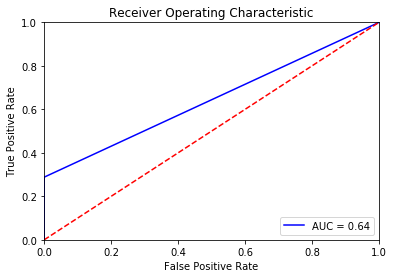

final results: 
- acc: 0.95
- F1: 0.45


In [57]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = threshold(y_pred, 0.5)

print("""final results: 
- acc: %.2f
- F1: %.2f""" % (acc(y_test, y_pred), f1_score(y_test, y_pred)))